## 0. EDA och filhantering

#### b) Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln.

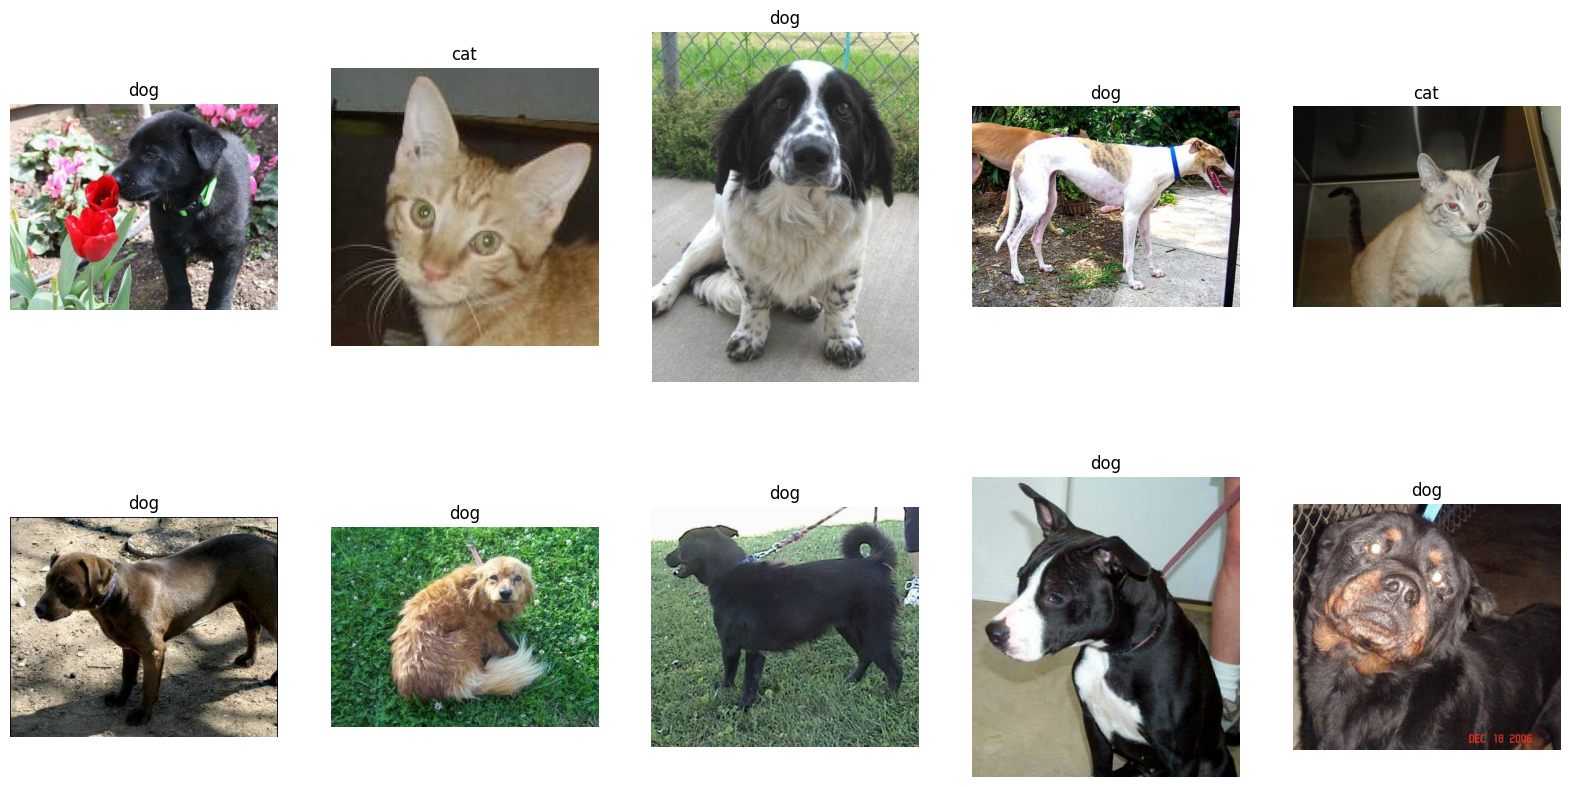

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from pathlib import Path
import os


# din lokala miljö
local_path = Path("experiment_small_data/original_data/train/train")

# Kontrollera om koden körs på Kaggle
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    data_path = Path("/kaggle/input/cats-and-dogs/experiment_small_data/original_data/train/train")
else:
    data_path = local_path

# Hämta alla bildsökvägar
all_images = list(data_path.glob("*.jpg"))

# Välj 10 slumpmässiga bilder
selected_images = np.random.choice(all_images, 10, replace=False)

# Plotta bilder och deras labels
plt.figure(figsize=(20, 10))
for i, image_path in enumerate(selected_images):
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = "dog" if "dog" in image_path.stem else "cat"
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.show()

In [2]:

# Skapa varje mapp separat istället för att sammanslå dem i en sträng
folders = [
    'experiment_small_data/test/cats', 'experiment_small_data/test/dogs', 
    'experiment_small_data/train/cats', 'experiment_small_data/train/dogs', 
    'experiment_small_data/val/cats', 'experiment_small_data/val/dogs', 
    'original_data/test/test', 'original_data/train/train'
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

### train|val|test split

In [3]:
import shutil

# Funktion för att dela upp och kopiera bilder
def distribute_images(source_folder, target_folder, num_train, num_val, num_test):
    dogs = list(source_folder.glob("*dog*.jpg"))
    cats = list(source_folder.glob("*cat*.jpg"))
    np.random.shuffle(dogs)
    np.random.shuffle(cats)

    # Definierar splits
    train_dogs, val_dogs, test_dogs = dogs[:800], dogs[800:1000], dogs[1000:1250]
    train_cats, val_cats, test_cats = cats[:800], cats[800:1000], cats[1000:1250]

    # Funktion för att kopiera filer
    def copy_files(files, path):
        for file in files:
            shutil.copy(file, path)

    # Skapa nya mappar om de inte redan finns
    os.makedirs(target_folder / 'train/dogs', exist_ok=True)
    os.makedirs(target_folder / 'val/dogs', exist_ok=True)
    os.makedirs(target_folder / 'test/dogs', exist_ok=True)
    os.makedirs(target_folder / 'train/cats', exist_ok=True)
    os.makedirs(target_folder / 'val/cats', exist_ok=True)
    os.makedirs(target_folder / 'test/cats', exist_ok=True)

    # Kopiera filer
    copy_files(train_dogs, target_folder / 'train/dogs')
    copy_files(val_dogs, target_folder / 'val/dogs')
    copy_files(test_dogs, target_folder / 'test/dogs')
    copy_files(train_cats, target_folder / 'train/cats')
    copy_files(val_cats, target_folder / 'val/cats')
    copy_files(test_cats, target_folder / 'test/cats')

# Anger käll- och målmappar baserat på om koden körs på Kaggle eller lokalt
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    source_folder = Path("/kaggle/input/cats-and-dogs/original_data/train/train")
    target_folder = Path("/kaggle/input/cats-and-dogs/experiment_small_data")
else:
    source_folder = Path("original_data/train/train")
    target_folder = Path("experiment_small_data")

# Distribuera bilder
distribute_images(source_folder, target_folder, 1600, 400, 500)

#### e) One-hot encoded

In [4]:
from tensorflow.keras.utils import to_categorical


def load_data(directory):
    # Definiera kategorier och initiera listor för bilder och labels
    categories = ['dogs', 'cats']
    images = []
    labels = []

    # Läs in bilder och deras labels
    for category in categories:
        category_path = Path(directory) / category
        class_num = categories.index(category)
        for img_path in category_path.iterdir():
            img = cv2.imread(str(img_path))
            if img is not None:
                img = cv2.resize(img, (224, 224))
                images.append(img)
                labels.append(class_num)

    # Konvertera till numpy arrays och one-hot encode labels
    images = np.array(images)
    labels = to_categorical(labels, num_classes=2)
    return images, labels

#  Kaggle eller lokalt
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    base_directory = Path("/kaggle/input/cats-and-dogs/experiment_small_data")
else:
    base_directory = Path("experiment_small_data")

# Läser in data från källan
train_images, train_labels = load_data(base_directory / 'train')
val_images, val_labels = load_data(base_directory / 'val')
test_images, test_labels = load_data(base_directory / 'test')

2024-05-13 09:29:54.163455: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 09:29:54.163556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 09:29:54.332068: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


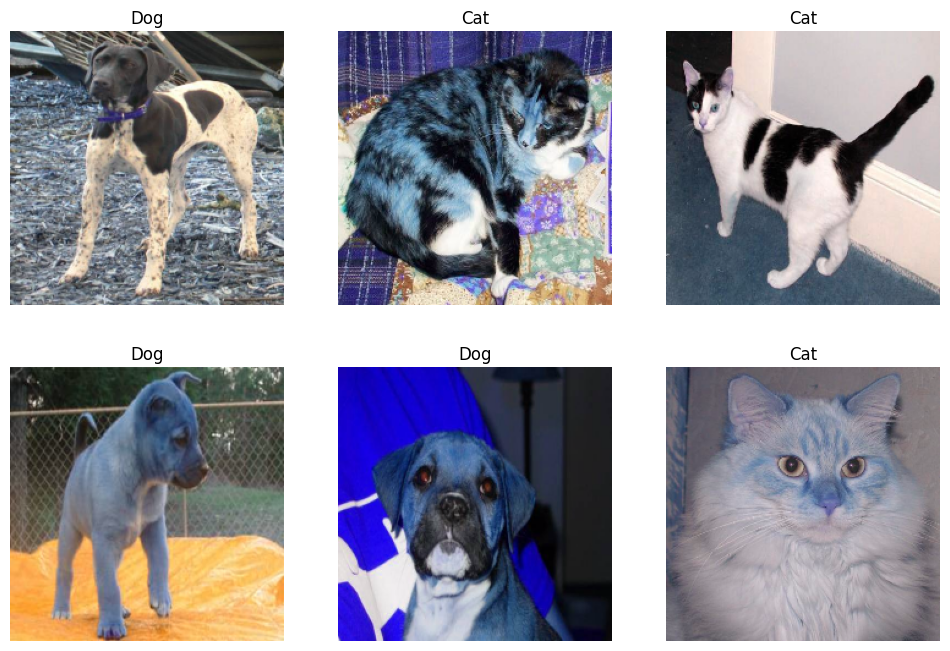

In [5]:

def plot_random_images_with_labels(images, labels):
    plt.figure(figsize=(12, 8))
    indices = np.random.choice(len(images), 6, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[idx])
        plt.title('Dog' if np.argmax(labels[idx]) == 0 else 'Cat')
        plt.axis('off')
    plt.show()

# Plotta slumpmässiga bilder med labels för att kontrollera korrekthet
plot_random_images_with_labels(test_images, test_labels)

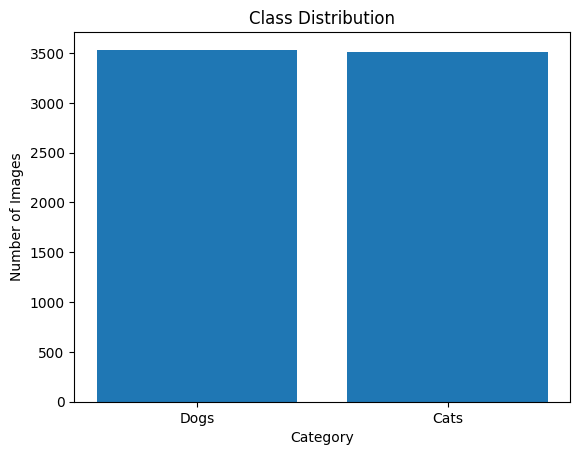

In [6]:

def plot_class_distribution(labels):
    # Beräkna antalet instanser av varje klass
    counts = np.sum(labels, axis=0)
    plt.bar(['Dogs', 'Cats'], counts)
    plt.title('Class Distribution')
    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.show()

# Plotta klassfördelningen för train set
plot_class_distribution(train_labels)

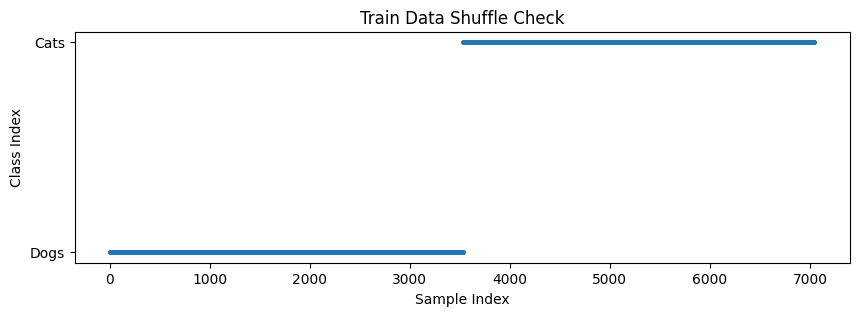

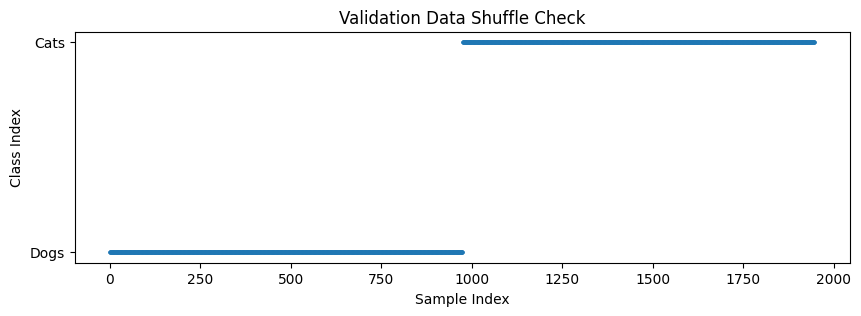

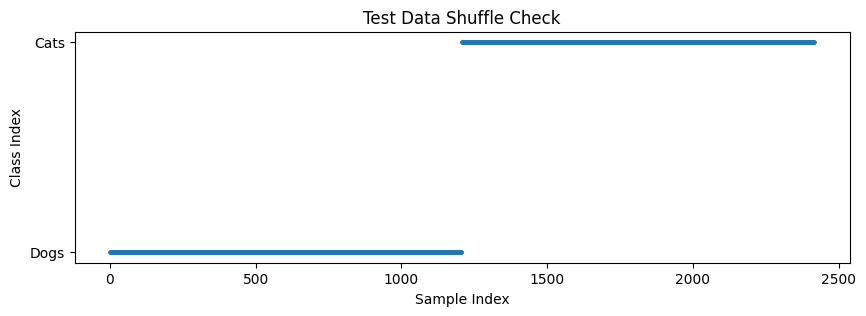

In [7]:
def plot_shuffle_check(labels, title="Shuffle Check"):
    # Konvertera one-hot encoded labels till enkel klassindikation
    indices = np.argmax(labels, axis=1)
    
    plt.figure(figsize=(10, 3))
    plt.plot(indices, marker='o', linestyle='', markersize=2)
    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Class Index')
    plt.yticks([0, 1], ['Dogs', 'Cats'])  # Antag att 0 är Dogs och 1 är Cats
    plt.show()

# Använd denna funktion för att plotta shuffle check för train, validation, och test datasets
plot_shuffle_check(train_labels, title="Train Data Shuffle Check")
plot_shuffle_check(val_labels, title="Validation Data Shuffle Check")
plot_shuffle_check(test_labels, title="Test Data Shuffle Check")

## Bildbehandling

Unique sizes found: 1
All images are the same size: [224, 224]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


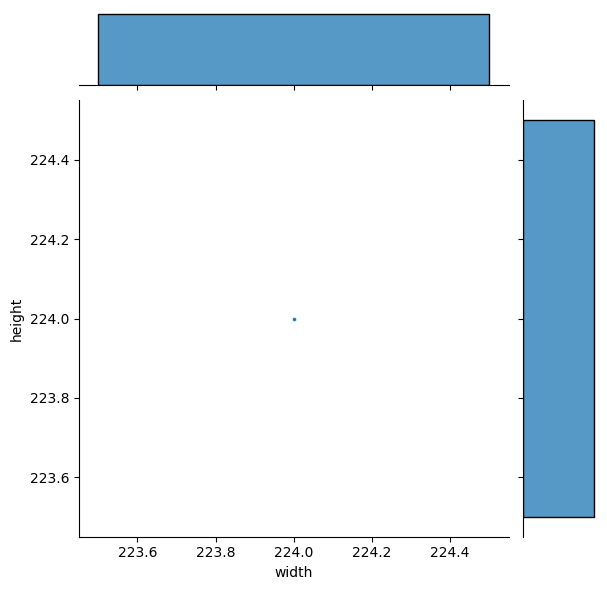

In [8]:
import pandas as pd

#  träningsdata beroende på miljö
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    base_directory = Path("/kaggle/input/cats-and-dogs/experiment_small_data/train")
else:
    base_directory = Path("experiment_small_data/train")

train_dogs_path = base_directory / 'dogs'
train_cats_path = base_directory / 'cats'

# Samlar alla bildsökvägar
train_images = list(train_dogs_path.glob("*.jpg")) + list(train_cats_path.glob("*.jpg"))

# Samlar bildstorlekar, med felhantering om en bild inte kan läsas
sizes = []
for image in train_images:
    img = cv2.imread(str(image))
    if img is not None:
        sizes.append((img.shape[0], img.shape[1]))
    else:
        print(f"Warning: Could not read image {image}")

# Skapa en DataFrame för att enklare hantera data
df_sizes = pd.DataFrame(sizes, columns=["height", "width"])

# Kontrollera unika storlekar
unique_sizes = df_sizes.drop_duplicates()
print(f"Unique sizes found: {len(unique_sizes)}")
if len(unique_sizes) == 1:
    print(f"All images are the same size: {unique_sizes.iloc[0].to_list()}")

# Plottar relationen mellan höjd och bredd på bilderna, med inställningar för att hantera tät data
sns.jointplot(data=df_sizes, x="width", y="height", kind="scatter", marker='.')
plt.show()

#### 1b Välj en lämplig bildstorlek

In [9]:
# För att ändra storlek på bilderna
def resize_images(image_paths, size=(224, 224)):
    for image_path in image_paths:
        img = cv2.imread(str(image_path))
        img_resized = cv2.resize(img, size)
        cv2.imwrite(str(image_path), img_resized)

resize_images(train_images)  # Uppdaterar alla träningsbilder till den nya storleken

#### 1c Spara bilder i numpy arrays

In [10]:
def load_images_to_array(image_paths, size=(224, 224)):
    images = np.array([cv2.resize(cv2.imread(str(image_path)), size) for image_path in image_paths])
    return images

# Ladda om bilderna och spara dem som en numpy array
train_images_array = load_images_to_array(train_images)

print(train_images_array.shape)

(7045, 224, 224, 3)


#### 1d Augmentera datan

Dataaugmentering är viktigt för att öka modellens generaliserbarhet och förhindra överanpassning, särskilt när vi har en begränsad mängd data. Augmentering kan inkludera rotationer, skalning, horisontell flipping, och färgvariationer.

Parametrarna för dataaugmentering väljs med hänsyn till typen av data, det specifika problemet som ska lösas och mängden tillgänglig data. Genom att överväga naturen av datan, typen av problem, tillgänglig mängd data och önskad inverkan kan man välja lämpliga parametrar. Det innebär att man kan experimentera med olika parametrar och utvärdera resultatet för att finjustera dataaugmenteringen för att uppnå bästa möjliga prestanda.

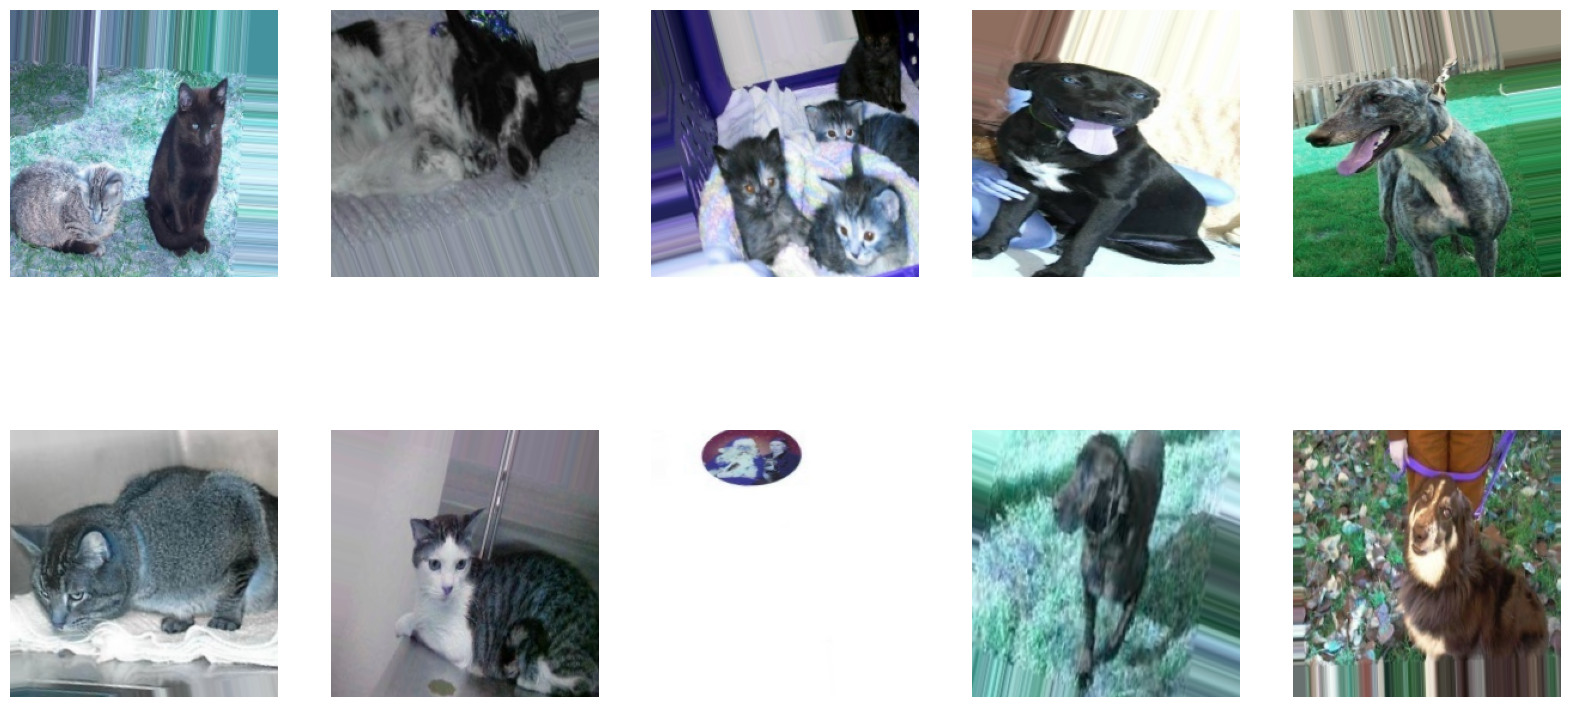

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definiera en ImageDataGenerator för data augmentering
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Visualisera några augmenterade bilder
augmented_images = next(data_gen.flow(train_images_array, batch_size=10))

plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(augmented_images[i].astype('uint8'))
    plt.axis('off')
plt.show()

#### 2. Träna modeller

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

def create_model(num_filters, dropout_rate):
    # Skapa en sekventiell modell
    model = Sequential([
        # Första konvolutionella lagret med ReLU-aktivering
        Conv2D(num_filters, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        # Första MaxPooling-lagret för att minska storleken på bilderna
        MaxPooling2D(2, 2),
        # Andra konvolutionella lagret, med dubbla antalet filter
        Conv2D(num_filters * 2, (3, 3), activation='relu'),
        # Andra MaxPooling-lagret för ytterligare storleksreduktion
        MaxPooling2D(2, 2),
        # Plattar ut datan för att kunna ansluta den till tätt anslutna lager
        Flatten(),
        # Fullt anslutet lager med 512 noder
        Dense(512, activation='relu'),
        # Dropout-lager för att minska risken för överanpassning
        Dropout(dropout_rate),
        # Output-lagret med en enda nod, använder sigmoid för binär klassificering
        Dense(1, activation='sigmoid')
    ])
    
    # Returnera den färdigbyggda modellen
    return model

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# basmappar för data beroende på körningsmiljön
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    base_path = Path("/kaggle/input/cats-and-dogs/experiment_small_data")
else:
    base_path = Path("experiment_small_data")

train_path = base_path / 'train'
val_path = base_path / 'val'
test_path = base_path / 'test'

# Skapar en bildgenerator för träningsdata med skalning av pixelvärdena
train_datagen = ImageDataGenerator(rescale=1./255)
# Använder bildgeneratorn för att läsa in bilder från träningsmappen
train_generator = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=20, class_mode='binary')

# Skapar en bildgenerator för valideringsdata, med samma skalning
val_datagen = ImageDataGenerator(rescale=1./255)
# Använder bildgeneratorn för att läsa in bilder från valideringsmappen
val_generator = val_datagen.flow_from_directory(val_path, target_size=(224, 224), batch_size=20, class_mode='binary')

Found 7045 images belonging to 2 classes.
Found 1947 images belonging to 2 classes.


In [15]:
# Skapar en ny CNN-modell med 32 filter i det första lagret och en dropout-rate på 50%
model_no_aug = create_model(32, 0.5)

# Kompilerar modellen med Adam-optimizer, används för att uppdatera nätverkets vikter baserat på träningsdatan
model_no_aug.compile(
    optimizer='adam',  # Optimeringsalgoritm, effektiv för stora datamängder och parametrar
    loss='binary_crossentropy',  # Förlustfunktion som är lämplig för binär klassificering
    metrics=['accuracy']  # accuracy används för att bedöma modellens prestanda under träning och validering
)

# Tränar modellen med data från train_generator, och använder val_generator för valideringsdata
history_no_aug = model_no_aug.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator  # Data som används för att validera modellens prestanda per epoch
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/353 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.4472 - loss: 10.3189

I0000 00:00:1715592776.782033     132 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715592776.801093     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 91/353 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - accuracy: 0.5091 - loss: 3.6363

W0000 00:00:1715592785.210427     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


352/353 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5510 - loss: 1.7395

W0000 00:00:1715592797.841972     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


353/353 ━━━━━━━━━━━━━━━━━━━━ 36s 75ms/step - accuracy: 0.5513 - loss: 1.7347 - val_accuracy: 0.6615 - val_loss: 0.6330
Epoch 2/10


W0000 00:00:1715592803.223248     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


353/353 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.7058 - loss: 0.5831 - val_accuracy: 0.7288 - val_loss: 0.5624
Epoch 3/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.7852 - loss: 0.4548 - val_accuracy: 0.7345 - val_loss: 0.5551
Epoch 4/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.8794 - loss: 0.2956 - val_accuracy: 0.7488 - val_loss: 0.6148
Epoch 5/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.9463 - loss: 0.1457 - val_accuracy: 0.7581 - val_loss: 0.8451
Epoch 6/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.9818 - loss: 0.0596 - val_accuracy: 0.7468 - val_loss: 0.8963
Epoch 7/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.9881 - loss: 0.0441 - val_accuracy: 0.7540 - val_loss: 1.1758
Epoch 8/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.9929 - loss: 0.0233 - val_accuracy: 0.7678 - val_loss: 1.0383
Epoch 9/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.9921 - loss: 0.0233 - val_accurac

In [16]:
# Skapar en ImageDataGenerator med flera dataaugmenteringsparametrar för träning
aug_train_datagen = ImageDataGenerator(
    rescale=1./255,  # Skalar om pixelvärdena till [0,1]
    rotation_range=40,  # Bilder roteras slumpmässigt inom detta intervall
    width_shift_range=0.2,  # Horisontella förskjutningar 
    height_shift_range=0.2,  # Vertikala förskjutningar 
    shear_range=0.2,  # Skjuvning av bilden
    zoom_range=0.2,  # Zooma in/ut bilder
    horizontal_flip=True  # Slumpmässigt spegelvända bilder horisontellt
)

# Använder datageneratorn för att läsa in bilder från träningsmappen
aug_train_generator = aug_train_datagen.flow_from_directory(
    train_path,  
    target_size=(224, 224),  
    batch_size=20, 
    class_mode='binary'  
)

model_aug = create_model(32, 0.5)

# Kompilerar modellen med Adam-optimizer och binär korsentropi som förlustfunktion
model_aug.compile(
    optimizer='adam',  # Optimeringsalgoritm
    loss='binary_crossentropy',  # Förlustfunktion för binär klassificering
    metrics=['accuracy']  # spårar tränings- och valideringsnoggrannhet
)

# Tränar modellen med augmenterade träningsdata och använder valgeneratorn för validering
history_aug = model_aug.fit(
    aug_train_generator,  # Augmenterad träningsdatagenerator
    epochs=10,
    validation_data=val_generator  # Data som används för att validera modellens prestanda per epoch
)

Found 7045 images belonging to 2 classes.
Epoch 1/10
  2/353 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.3875 - loss: 1.3950

W0000 00:00:1715593003.290491     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  7/353 ━━━━━━━━━━━━━━━━━━━━ 3:09 547ms/step - accuracy: 0.4066 - loss: 2.7275

W0000 00:00:1715593006.478334     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.5221 - loss: 0.9384

W0000 00:00:1715593087.300335     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


353/353 ━━━━━━━━━━━━━━━━━━━━ 94s 251ms/step - accuracy: 0.5222 - loss: 0.9378 - val_accuracy: 0.5675 - val_loss: 0.6885
Epoch 2/10


W0000 00:00:1715593091.727919     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


353/353 ━━━━━━━━━━━━━━━━━━━━ 88s 244ms/step - accuracy: 0.5726 - loss: 0.6815 - val_accuracy: 0.5645 - val_loss: 0.6797
Epoch 3/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 88s 246ms/step - accuracy: 0.5727 - loss: 0.6812 - val_accuracy: 0.6127 - val_loss: 0.6637
Epoch 4/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 88s 244ms/step - accuracy: 0.5843 - loss: 0.6702 - val_accuracy: 0.5942 - val_loss: 0.6670
Epoch 5/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 88s 244ms/step - accuracy: 0.5775 - loss: 0.6786 - val_accuracy: 0.6487 - val_loss: 0.6240
Epoch 6/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 88s 245ms/step - accuracy: 0.6106 - loss: 0.6567 - val_accuracy: 0.6405 - val_loss: 0.6392
Epoch 7/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 89s 246ms/step - accuracy: 0.6281 - loss: 0.6487 - val_accuracy: 0.6323 - val_loss: 0.6473
Epoch 8/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 88s 244ms/step - accuracy: 0.6331 - loss: 0.6543 - val_accuracy: 0.6687 - val_loss: 0.6233
Epoch 9/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 89s 246ms/step - accuracy: 0.6429 - loss: 0.6319 - val

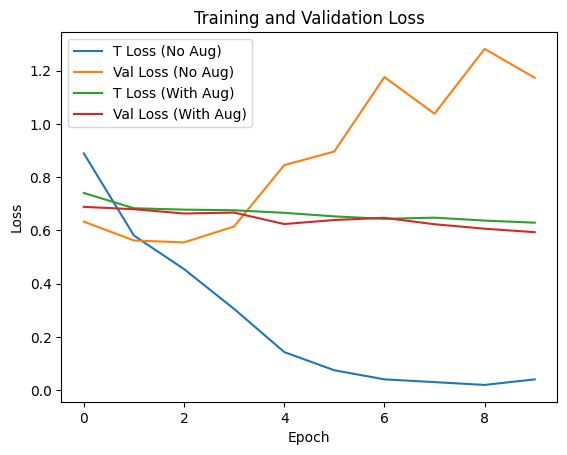

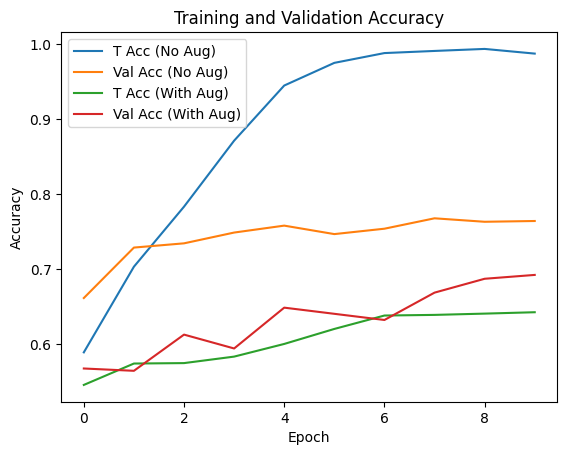

In [17]:
# Visualiserar loss-kurvorna
plt.plot(history_no_aug.history['loss'], label='T Loss (No Aug)')
plt.plot(history_no_aug.history['val_loss'], label='Val Loss (No Aug)')
plt.plot(history_aug.history['loss'], label='T Loss (With Aug)')
plt.plot(history_aug.history['val_loss'], label='Val Loss (With Aug)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Visualiserar accuracy-kurvorna
plt.plot(history_no_aug.history['accuracy'], label='T Acc (No Aug)')
plt.plot(history_no_aug.history['val_accuracy'], label='Val Acc (No Aug)')
plt.plot(history_aug.history['accuracy'], label='T Acc (With Aug)')
plt.plot(history_aug.history['val_accuracy'], label='Val Acc (With Aug)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

### Uppgift 2b: Förändra

Genom att lägga till en extra Convolutional layer ökar modellens komplexitet och förmåga att extrahera abstrakta och komplexa mönster från bilderna. Detta kan vara särskilt användbart när datan innehåller många olika detaljer och mönster som modellen behöver lära sig att skilja mellan.

In [18]:
def modified_model(num_filters, dropout_rate):
    model = Sequential([
        Conv2D(num_filters, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(num_filters * 2, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(num_filters * 4, (3, 3), activation='relu'),  # Extra Convolutional layer
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    return model

# Tränar den modifierade modellen
mod_model = modified_model(32, 0.5)
mod_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mod_history = mod_model.fit(aug_train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
  2/353 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.5250 - loss: 1.1061

W0000 00:00:1715593900.791698     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/353 ━━━━━━━━━━━━━━━━━━━━ 49s 252ms/step - accuracy: 0.5262 - loss: 0.8433

W0000 00:00:1715593940.014042     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


352/353 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.5468 - loss: 0.7700

W0000 00:00:1715593985.251695     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


353/353 ━━━━━━━━━━━━━━━━━━━━ 98s 254ms/step - accuracy: 0.5470 - loss: 0.7697 - val_accuracy: 0.5804 - val_loss: 0.6799
Epoch 2/10


W0000 00:00:1715593990.401373     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


353/353 ━━━━━━━━━━━━━━━━━━━━ 87s 241ms/step - accuracy: 0.5664 - loss: 0.6855 - val_accuracy: 0.5691 - val_loss: 0.6740
Epoch 3/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 86s 240ms/step - accuracy: 0.5813 - loss: 0.6735 - val_accuracy: 0.5624 - val_loss: 0.6709
Epoch 4/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 87s 241ms/step - accuracy: 0.6002 - loss: 0.6690 - val_accuracy: 0.6507 - val_loss: 0.6251
Epoch 5/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 87s 242ms/step - accuracy: 0.6376 - loss: 0.6407 - val_accuracy: 0.6687 - val_loss: 0.6189
Epoch 6/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 87s 241ms/step - accuracy: 0.6306 - loss: 0.6435 - val_accuracy: 0.7026 - val_loss: 0.5997
Epoch 7/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 87s 243ms/step - accuracy: 0.6554 - loss: 0.6237 - val_accuracy: 0.6959 - val_loss: 0.5849
Epoch 8/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 87s 243ms/step - accuracy: 0.6564 - loss: 0.6176 - val_accuracy: 0.6805 - val_loss: 0.6008
Epoch 9/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 88s 243ms/step - accuracy: 0.6744 - loss: 0.6115 - val

In [19]:
# Evaluerar modellen på valideringsdatan
val_loss, val_acc = mod_model.evaluate(val_generator)
print("Validation Accuracy: ", val_acc)

98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7459 - loss: 0.5395
Validation Accuracy:  0.7457627058029175


### Uppgift 2c: Välj en Modell och Gör Inferens

Det är uppmuntrande att se att testnoggrannheten är liknande eller till och med lite högre än valideringsnoggrannheten. Detta tyder på att modellen generaliserar väl till osedd data och inte visar tecken på overfitting.

In [20]:
# Skapar en ImageDataGenerator för testdata med pixelvärdena till intervallet [0,1]
test_datagen = ImageDataGenerator(rescale=1./255)

# Skapar en datagenerator för testmappen, med specificerad bildstorlek och batchstorlek utan att blanda datan
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=20, 
    class_mode='binary',
    shuffle=False  # Data blandas inte, vilket är viktigt för testning för att behålla ordning på label och prediktion
)

# den modifierade modellen används
test_loss, test_acc = mod_model.evaluate(test_generator)  # Utvärderar modellen på testdatan

print("Test Accuracy: ", test_acc)

Found 2417 images belonging to 2 classes.
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.7497 - loss: 0.5519
Test Accuracy:  0.7314853072166443


W0000 00:00:1715594799.606324     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### Uppgift 2d

### Sammanfattning av forskningsartikeln "Xception: Deep Learning with Depthwise Separable Convolutions"

Artikeln presenterar en ny arkitektur för djupa neuronnätverk som kallas Xception, inspirerad av Inception-moduler använda i tidigare neuronnätverksarkitekturer. Xception-arkitekturen baseras på djup separerbara konvolutioner (depthwise separable convolutions), vilka erbjuder en mer effektiv användning av modellparametrarna jämfört med Inception V3. Detta ger förbättrade resultat utan att öka antalet parametrar.

Xception använder en typ av konvolution som är en utveckling av Inception-moduler. Istället för att använda flera parallella paths av konvolutioner, separerar Xception processen i två steg: en djup konvolution följt av en punktvis konvolution. Detta innebär att varje kanal i indatat behandlas separat innan resultatet kombineras, vilket optimerar behandlingen av rymd- och kanalkorrelationer inom datan.

Xception-testerna genomfördes på två stora bildklassificeringsdataset, ImageNet och JFT. Resultaten visade att Xception presterade marginellt bättre än Inception V3 på ImageNet och avsevärt bättre på JFT-datasetet. Detta stöder tesen att arkitekturen kan hantera större och mer komplexa dataset mer effektivt.

Artikeln beskriver även det tekniska genomförandet av träningen för Xception, där olika optimeringsstrategier användes för ImageNet och JFT. Detaljerad information ges om hur hyperparametrar såsom inlärningshastighet optimerades för att passa Xception-modellen.
Slutligen diskuteras framtida riktningar för att ytterligare utforska och förbättra arkitekturer baserade på djupa separerbara konvolutioner. Författarna antyder att det kan finnas ytterligare fördelar med att utforska mellanliggande punkter på spektrumet mellan traditionella Inception-moduler och djupa separerbara konvolutioner.

In [77]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# Laddar förtränad Xception modell utan toppskiktet
base_model = Xception(weights='imagenet', include_top=False)

# Lägger till ett globalt genomsnittligt pooling-lager
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Lägger till ett fullt anslutet lager
x = Dense(1024, activation='relu')(x)

# Lägger till ett logit-lager för två klasser (katter och hundar)
predictions = Dense(2, activation='softmax')(x)

# Sätter ihop den nya modellen
model = Model(inputs=base_model.input, outputs=predictions)

# Fryser alla lager i basmodellen
for layer in base_model.layers:
    layer.trainable = False


In [50]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Ändra output-lagret till att använda sigmoid för binär klassificering
model = Model(inputs=base_model.input, outputs=Dense(1, activation='sigmoid')(x))

# Kompilerar modellen för vanliga binära labels
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# skapar ett EarlyStopping-objekt
early_stopper = EarlyStopping(
    monitor='val_loss', 
    patience=3,
    mode='min',
    verbose=1
)

# Tränar modellen med EarlyStopping
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Epoch 1/10
  1/353 ━━━━━━━━━━━━━━━━━━━━ 1:29:31 15s/step - accuracy: 0.9500 - loss: 0.2670

W0000 00:00:1715600488.372748     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


299/353 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9965 - loss: 0.0196

W0000 00:00:1715600528.956179     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9963 - loss: 0.0197

W0000 00:00:1715600538.256011     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


353/353 ━━━━━━━━━━━━━━━━━━━━ 74s 166ms/step - accuracy: 0.9963 - loss: 0.0197 - val_accuracy: 0.9866 - val_loss: 0.1063
Epoch 2/10


W0000 00:00:1715600546.833784     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


353/353 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - accuracy: 0.9977 - loss: 0.0068 - val_accuracy: 0.9789 - val_loss: 0.1344
Epoch 3/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - accuracy: 0.9925 - loss: 0.0269 - val_accuracy: 0.9774 - val_loss: 0.1285
Epoch 4/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - accuracy: 0.9966 - loss: 0.0099 - val_accuracy: 0.9856 - val_loss: 0.0730
Epoch 5/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - accuracy: 0.9999 - loss: 6.2191e-04 - val_accuracy: 0.9866 - val_loss: 0.1070
Epoch 6/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - accuracy: 0.9988 - loss: 0.0037 - val_accuracy: 0.9882 - val_loss: 0.0619
Epoch 7/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - accuracy: 0.9996 - loss: 0.0035 - val_accuracy: 0.9866 - val_loss: 0.0739
Epoch 8/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - accuracy: 0.9982 - loss: 0.0062 - val_accuracy: 0.9851 - val_loss: 0.0487
Epoch 9/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - accuracy: 0.9998 - loss: 0.0011 -

In [51]:
# Tina de övre lagren i basmodellen
for layer in base_model.layers[-33:]:
    layer.trainable = True

# Kompilerar om modellen för finjustering
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Tränar den finjusterade datan
history_finetuning = model.fit(
    train_generator, 
    epochs=10, 
    validation_data=val_generator, 
    callbacks=[early_stopper]
)


Epoch 1/10
  1/353 ━━━━━━━━━━━━━━━━━━━━ 1:29:57 15s/step - accuracy: 1.0000 - loss: 6.2090e-06

W0000 00:00:1715601115.487068     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


177/353 ━━━━━━━━━━━━━━━━━━━━ 25s 146ms/step - accuracy: 0.9989 - loss: 0.0015

W0000 00:00:1715601141.071226     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9990 - loss: 0.0016

W0000 00:00:1715601164.718005     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


353/353 ━━━━━━━━━━━━━━━━━━━━ 73s 164ms/step - accuracy: 0.9990 - loss: 0.0016 - val_accuracy: 0.9882 - val_loss: 0.0807
Epoch 2/10


W0000 00:00:1715601173.276150     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


353/353 ━━━━━━━━━━━━━━━━━━━━ 48s 134ms/step - accuracy: 0.9999 - loss: 3.6857e-04 - val_accuracy: 0.9877 - val_loss: 0.0865
Epoch 3/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 48s 134ms/step - accuracy: 0.9998 - loss: 6.9422e-04 - val_accuracy: 0.9872 - val_loss: 0.0852
Epoch 3: early stopping


In [52]:
# Utvärdera modellen på valideringsdatan
val_loss, val_acc = model.evaluate(val_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

# Utvärdera modellen på testdatan
test_loss, test_acc = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.9901 - loss: 0.0633
Validation Loss: 0.08520008623600006
Validation Accuracy: 0.9871597290039062
121/121 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9880 - loss: 0.1467
Test Loss: 0.12400981038808823
Test Accuracy: 0.9867604374885559


W0000 00:00:1715601294.359484     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


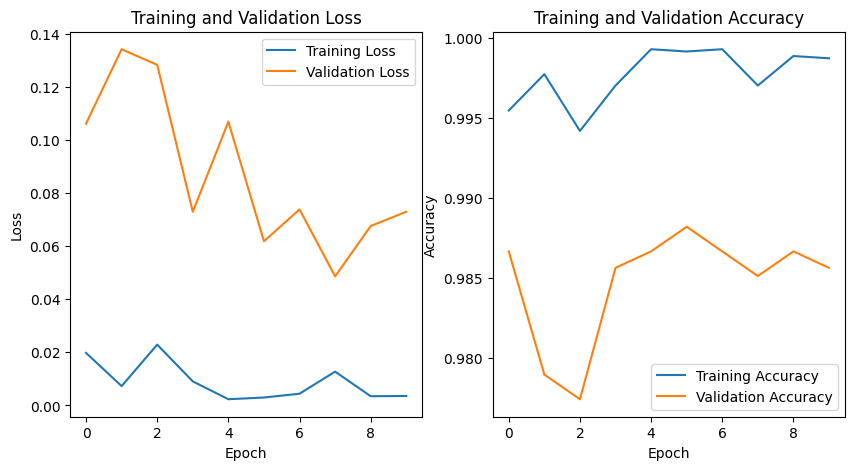

In [71]:
import matplotlib.pyplot as plt

# Plotta träning och validering för förlust
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotta träning och validering för noggrannhet
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step


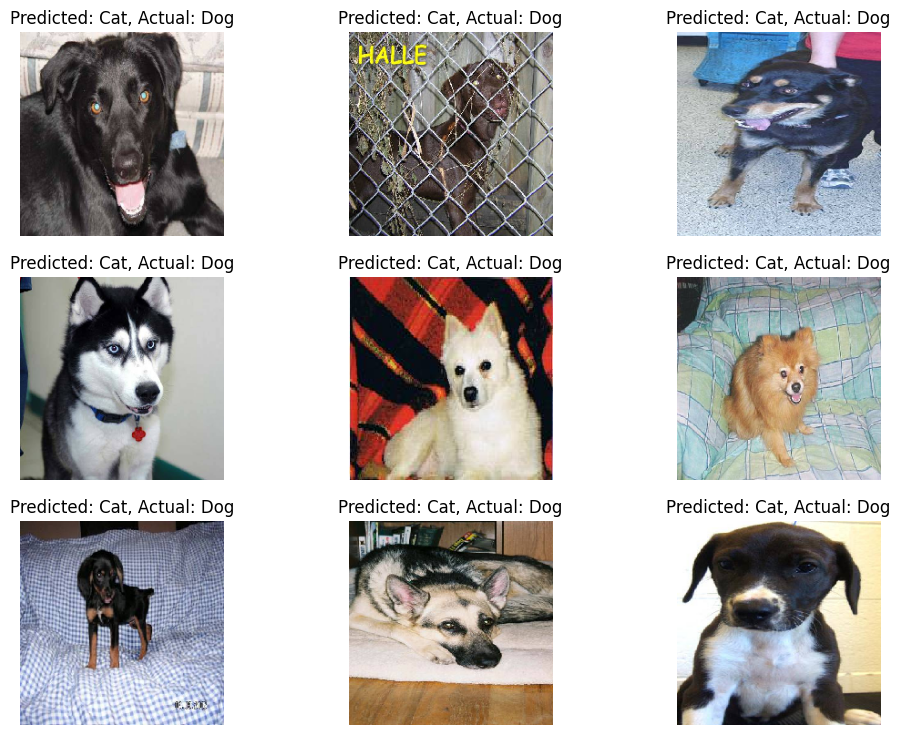

In [70]:
# Förutsägelser på testdata
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int)

# Hämtar etiketter från generatorn
true_classes = test_generator.classes

# Visar bilder med förutsägelser och etiketter
plt.figure(figsize=(12, 9))
for i in range(9):
    img, label = next(test_generator)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img[0])
    plt.title(f'Predicted: {"Dog" if predicted_classes[i] == 1 else "Cat"}, Actual: {"Dog" if label[0] == 1 else "Cat"}')
    plt.axis('off')
plt.show()


#### Vad är Transfer Learning?
Transfer learning är en teknik inom maskininlärning där en modell som har tränats för en uppgift återanvänds som utgångspunkt för en modell på en annan relaterad uppgift. Det är särskilt användbart i situationer där datamängden för den nya uppgiften är begränsad.

#### Tillvägagångssätt
Man börjar med en modell som har tränats på ett stort och brett dataset, såsom ImageNet, som har lärt sig ett brett spektrum av drag som är användbara för olika typer av bildklassificeringsuppgifter.

Istället för att starta från grunden med den nya uppgiften, kan man återanvända de lägre lagren från den förtränade modellen. Dessa lager har vanligtvis lärt sig att identifiera allmänna drag som kanter och texturer.

De övre lagren av modellen, som är mer specialiserade på specifika drag för de uppgifter som modellen tränades på från början, kan justeras eller tränas om för att passa den nya specifika uppgiften.